In [1]:
import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

In [2]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LK.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]


In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

In [5]:
print(LK.shape, len(pred))
acc = model.score_
print(acc)

(610, 1379) 610
0.136


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (102.0, 648.0, 0.1574074074074074, 0.37777777777777777, 0.9876770942283921, 0.136, 0.9967757412916227, 0.864, 0.6222222222222222)


# Mutual information maximizer (MIM)

test 0.5567534433765046 0.06105108778505662
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (148.0, 568.0, 0.2605633802816901, 0.4169014084507042, 0.9907777236564377, 0.20670391061452514, 0.9966192490486534, 0.7932960893854749, 0.5830985915492958)


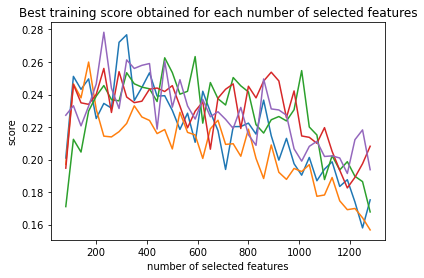

In [7]:
#Define parameters for MIM method
N = np.arange(80,1300,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(80,1300,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    

# Hybrid methods

# Mutual information and stimulated annealing

In [ ]:
#Define parameters for MI + stimulated annealing method
N = np.array([700])
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_iter': 1400, 'n_neighbors': 3, 'p_mutate': 0.1, 'c': 1, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LK, FamiliesClusters, compute_precision,True, 5,  MI_stimulated_annealing, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 

# Mutual information and genetic feature selection

In [ ]:
#Define parameters for MI + genetic algorithm method
N = np.array([700])                            
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'n_population': 300, 'crossover_proba': 0.5, 'mutation_proba': 0.2, 'n_generations': 120, 'tournament_size': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LK, FamiliesClusters, compute_precision,True, 5,  MI_genetic_fs, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 